In [1]:
# Map of observations during Helene
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cf
import geopandas as gpd
import numpy as np
import matplotlib.cm as cm


In [2]:
# Define some colors
noaa_blue = '#1D70B7'
usgs_green = '#2E8B57'

In [3]:
def drift_clean(df1,time_frame=None):
    """Takes a dataframe as a single argument, and returns the dataframe with NaNs dropped from sig wave height,
    and a datetime64 array to facilitate plotting (via, e.g., drift_swhplt()). The dataframe can
    come from a pandas read of a json or csv file (pd.read_json or pd.read_csv), or from the pickle file
    that Jacob usually sends out after a hurricane has passed."""
    df1a = df1.loc[df1.significant_height.dropna().index]
    dt1 = df1a.index.values
    if time_frame is not None:
        df1b = df1a.loc[(df1a.index >= time_frame[0]) & (df1a.index <= time_frame[1])]
        dt1 = df1b.index.values
        return dt1, df1b
    return dt1, df1a

In [4]:
wl_data_dir=       'D:/crs/proj/2025_NOPP_comparison/helene_water_level/'
track_data_dir =   'D:/crs/proj/2025_NOPP_comparison/helene_best_track/'
drifter_data_dir = 'D:/crs/proj/2025_NOPP_comparison/helene_drifters/'
figure_dir = 'D:/crs/proj/2025_NOPP_comparison/helene_figs/'

# load drifter data
with open(drifter_data_dir+'hurricane_helene_drifter_data_v0.pickle', 'rb') as f1:
    spots = pickle.load(f1)

df = pd.read_csv(wl_data_dir+'water_level_sites.csv')
noaa_df = df[df['type'] == 'NOAA tide gauge']
rdg_df = df[df['type'] == 'USGS rapid deployment gauge']
st_df = df[df['type'] == 'USGS pressure sensor']
ndbc_df = df[df['type'] == 'NDBC wave buoy']

C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_34304\2171897743.py:8: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  spots = pickle.load(f1)


In [5]:
ndbc_df

,name,longname,longitude,latitude,type,Water depth (m),Exposure,Sensor Elevation (m NAVD88),NAVD88,MLLW,MSL,MHHW,Sample Interval (s),Comment
64,42036,NDBC 42036 (LLNR 855),-87.508,28.501,NDBC wave buoy,50.9,ocean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,42022,NDBC 42022 - C12 - WFS Central Buoy,-83.741,27.505,NDBC wave buoy,50.0,ocean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,42098,NDBC 42098 - Egmont Channel Entrance,-82.931,27.590,NDBC wave buoy,14.0,ocean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,42013,NDBC 42013 - C10 - WFS Central Buoy,-82.924,27.173,NDBC wave buoy,25.0,ocean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,42905,NDBC 42095 - Satan Shoal,-81.968,24.409,NDBC wave buoy,100.0,ocean,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
gd1 = gpd.read_file(track_data_dir+'AL092024_pts.shp')
lt1 = gd1.LAT
ln1 = gd1.LON
hurpth = np.array(list(zip(ln1,lt1)))
hhmm = []
for i in gd1.HHMM:
    hhmm.append(i[:2] + 'Z')


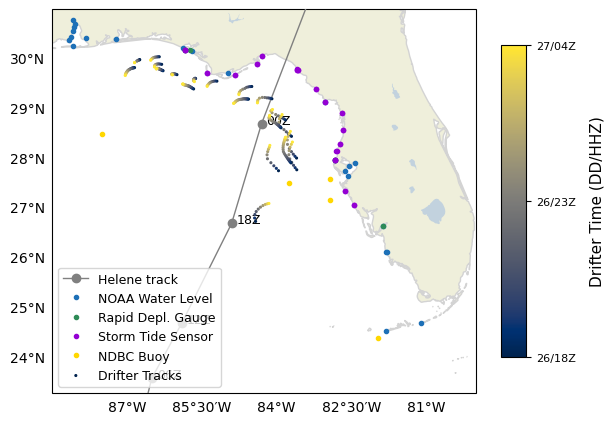

In [7]:
cpc = crs.PlateCarree()

fig1 = plt.figure()
ax1 = fig1.add_axes((0.12, 0.125, 0.8, 0.8),projection=cpc)
ax1.set_extent([-88.5, -80, 23.3, 31])
ax1.add_feature(cf.LAND, edgecolor='lightgray', linewidth=1, zorder=-1)
#ax1.add_feature(cf.COASTLINE)
ax1.add_feature(cf.LAKES, alpha=0.5)

## That sets up the plot.  To plot something, I'll just open the shapefile with the nhc best track
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax1.plot(hurpth[:,0],hurpth[:,1],'o-', markersize=6, linewidth=1, c='gray', zorder=5, label='Helene track')
offset = 0.1
for xy in range(len(hhmm)):
    ax1.annotate(hhmm[xy], (hurpth[xy, 0]+offset, hurpth[xy, 1]), size=9, annotation_clip=True)
ax1.plot(noaa_df['longitude'],noaa_df['latitude'],'.',color=noaa_blue, label='NOAA Water Level')
ax1.plot(rdg_df['longitude'],rdg_df['latitude'],'.',c=usgs_green,label='Rapid Depl. Gauge')
ax1.plot(st_df['longitude'],st_df['latitude'],'.',c='darkviolet',label='Storm Tide Sensor')
ax1.plot(ndbc_df['longitude'],ndbc_df['latitude'],'.',c='gold',label='NDBC Buoy')

# Plot the drifter tracks
first_one=True
for btype in spots.keys():
    for buoy1 in spots[btype].keys():
        df1 = spots[btype][buoy1]
        dt1, df1a = drift_clean(df1, ("2024-09-26 18:00", "2024-09-27 04:00"))
        # add label to appear in legend for first one plotted
        if first_one:
            sct1 = ax1.scatter(df1a.longitude, df1a.latitude, s=6, marker='.', c=dt1, cmap=cm.cividis, zorder=6, label='Drifter Tracks')
            first_one=False
        sct1 = ax1.scatter(df1a.longitude, df1a.latitude, s=6, marker='.', c=dt1, cmap=cm.cividis, zorder=6)
        if 'swift' in btype:
            bt2 = 'SWIFT'
            buoy2 = buoy1
        elif 'spot' in btype:
            bt2 = 'SPT'
            # This line uses the last four digits of the buoy number to annotate it on the map
            buoy2 = buoy1[-4:]
        elif 'dwsd' in btype:
            bt2 = 'DWSD'
            # This line uses the last four digits of the buoy number to annotate it on the map
            buoy2 = buoy1[-4:]
            sct1a = sct1
            dt1a = dt1
        # This would label the drifters
        #ax1.annotate(f'{bt2}_{buoy2}', xy=(df1a.longitude[0], df1a.latitude[0]), size=8)

gl.top_labels = False  # Turn off labels on the top
gl.right_labels = False  # Turn off labels on the right
gl.xlines = False  # Hide longitude gridlines
gl.ylines = False  # Hide latitude gridlines
ax1.legend(loc='lower left',fontsize=9)

# # Add a North arrow
# ax1.text(0.05, 0.9, 'N', transform=ax1.transAxes, ha='center', va='center', fontsize=16,
#         fontweight='bold', color='black')
# ax1.annotate('', xy=(0.05, 0.85), xytext=(0.05, 0.75), xycoords='axes fraction',
#             arrowprops=dict(facecolor='black', width=4, headwidth=10))



dtticks = dt1a[[0,int(dt1a.size//2),-1]]
cbticks = []
dstr = []
for i in dtticks:
    cbticks.append(i.tolist())
    dstr.append(str(i)[8:13].replace('T','/') + 'Z')
cax = fig1.add_axes((0.89,0.2,0.04,0.65))
cb1 = plt.colorbar(sct1a,cax=cax, orientation='vertical', ticks=cbticks)
cb1.set_ticklabels(dstr,size=8)
cb1.set_label('Drifter Time (DD/HHZ)', fontsize=11, labelpad=10)  # Add caption

plt.savefig(figure_dir+'observations_map_helene.png', dpi=200, bbox_inches='tight')